### Step 1: Enable IMAP access and generate credentials

The first step is to "Enable IMAP access" in the "IMAP access" section of Gmail, which will allow us to access our account from any device.

In [1]:
import imaplib
import email
from email.header import decode_header

import pandas as pd
from tqdm import tqdm

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from wordcloud import WordCloud, STOPWORDS


Step 2: Log in to Gmail with the credentials.

The second step is to generate an app password, which we will use to log in to Gmail from Python.

In [2]:
user, password = "amababhale@gmail.com", "pyxv wzbo vlou jmai"

imap_url ='imap.gmail.com'
my_mail = imaplib.IMAP4_SSL(imap_url)
my_mail.login(user, password)

# Select All Emails from the Inbox
my_mail.select('Inbox')
total_correos = int(my_mail.select('Inbox')[1][0].decode('utf-8'))
total_correos


91

Step 3: Retrieve Emails

In [3]:
email_df = pd.DataFrame(columns=['Date','From','Subject'], index=range(total_correos,0,-1))

for i in tqdm(range(total_correos, 0, -1)):
    data = my_mail.fetch(str(i),'(UID RFC822)')
    arr = data[1][0]
    if isinstance(arr, tuple):
        try: msg = email.message_from_string(str(arr[1],'utf-8'))
        except: msg = email.message_from_string(str(arr[1],'latin-1'))
        new_row = pd.Series({"Date":msg['Date'] , "From":msg['from'], "Subject":msg['subject']})
    #email_df = email_df.append(new_row, ignore_index=True)
    email_df = pd.concat([email_df, pd.DataFrame([new_row])], ignore_index=True)
    
email_df = email_df.dropna(how='all').reset_index(drop=True) # Clean empty rows
email_df

100%|██████████| 91/91 [01:37<00:00,  1.07s/it]


,Date,From,Subject
0,"Thu, 12 Dec 2024 22:34:45 -0800",The Google Workspace Team <workspace-noreply@g...,Annual Reminder about Google Terms and Policies
1,"Wed, 11 Dec 2024 21:42:48 +0530",Aditya katle <aditya.katle2003@gmail.com>,
2,"Tue, 10 Dec 2024 17:23:57 +0530",Aditya katle <aditya.katle2003@gmail.com>,
3,"Mon, 9 Dec 2024 18:52:04 +0530",Aditya katle <aditya.katle2003@gmail.com>,Internship Thesis
4,"Mon, 9 Dec 2024 14:09:12 +0530",RAJAT DHAWALE <rajatdhawale96@gmail.com>,Complain
...,...,...,...
86,"Sat, 30 Nov 2024 11:00:08 GMT",Google <no-reply@accounts.google.com>,Security alert
87,"Sat, 30 Nov 2024 09:13:53 GMT",Google <no-reply@accounts.google.com>,2-Step Verification turned on
88,"Sat, 30 Nov 2024 09:13:48 GMT",Google <no-reply@accounts.google.com>,Security alert
89,"Sat, 30 Nov 2024 01:13:11 -0800",Google <no-reply@google.com>,=?UTF-8?Q?=E2=9C=85_Finish_setting_up_your_new...


Since a large number of emails are being extracted, the process tends to take some time (2168 emails ~ 17 minutes). For that reason, we save the email_df dataframe to a CSV file.

In [4]:
email_df.to_csv('Data/email_df.csv', index=False, encoding='utf-8')
print(msg.keys())

['Delivered-To', 'Received', 'X-Received', 'ARC-Seal', 'ARC-Message-Signature', 'ARC-Authentication-Results', 'Return-Path', 'Received', 'Received-SPF', 'Authentication-Results', 'DKIM-Signature', 'X-Google-DKIM-Signature', 'X-Gm-Message-State', 'X-Gm-Gg', 'X-Google-Smtp-Source', 'X-Received', 'MIME-Version', 'From', 'Date', 'Message-ID', 'Subject', 'To', 'Content-Type']


 Note: Using <b>msg.keys()</b>, you can view all the possible variables to extract. The reason we focus on 3 variables is that they are the most useful for analysis. A sample of values for all the variables is available in the <b>msg_keys.txt</b> file in the Resources folder.

### Step 4: Data Cleaning and Transformation

##### 4.1. Column Date

In [5]:
def clean_date(x):
    if ',' not in x: x = ', ' + x
    if '(' in x: x = ' '.join(x.split(' ')[:-1])
    x = ' '.join(x.split(' ')[:-1])
    return x


In [6]:
###Transform Date "Wed, 14 Sep 2022 17:38:23 +0000 (UTC)"
#Extract 'H_M_S' column

email_df['Date'] = email_df['Date'].apply(lambda x: clean_date(x)) # The result is "Wed, 14 Sep 2022 17:38:23"
email_df['Date'] = email_df['Date'].str.split(', ').str[-1]           # The result is "14 Sep 2022 17:38:23"
email_df['H_M_S'] = email_df['Date'].apply(lambda x: x[-8:])          # The result is "17:38:23"

# Extract column 'Hour'
email_df['Hour'] = email_df['H_M_S'].apply(lambda x: x[:2]+'h-'+str(int(x[:2])+1).zfill(2)+'h')    # The result is "17h-18h"

# Extract column 'Date'
email_df['Date'] = email_df['Date'].apply(lambda x: x[:-9] if len(x[:-9])==11 else '0'+x[:-9] )    # The result is "14 Sep 2022"
email_df['Date'] = pd.to_datetime(email_df['Date'], format='%d %b %Y')                             # The result is "2022-09-14"

# Extract column 'WeekDay'
email_df['WeekDay'] = email_df['Date'].dt.strftime('%A')                                           # The result is "Wednesday"  

email_df.head()

,Date,From,Subject,H_M_S,Hour,WeekDay
0,2024-12-12,The Google Workspace Team <workspace-noreply@g...,Annual Reminder about Google Terms and Policies,22:34:45,22h-23h,Thursday
1,2024-12-11,Aditya katle <aditya.katle2003@gmail.com>,,21:42:48,21h-22h,Wednesday
2,2024-12-10,Aditya katle <aditya.katle2003@gmail.com>,,17:23:57,17h-18h,Tuesday
3,2024-12-09,Aditya katle <aditya.katle2003@gmail.com>,Internship Thesis,18:52:04,18h-19h,Monday
4,2024-12-09,RAJAT DHAWALE <rajatdhawale96@gmail.com>,Complain,14:09:12,14h-15h,Monday


##### 4.2: From and Subject column

In [7]:
def extract_email_from(x):
    x_mod = x.split('<')[-1].split('>')[0]
    return x_mod

def extract_name_from(x):
    text, encoding = decode_header(x)[0]
    if not encoding and isinstance(text, str):
        text = ' '.join(text.split(' ')[:-1])
    else:
        text = text.decode('utf-8', errors='ignore')
        
    text = text.replace('"', '')
    return text

def clean_subject(x):
    if x:
        text, encoding = decode_header(x)[0]
        try:
            text = text.decode('utf-8', errors='ignore')
        except:
            pass
    else:
        text = x
    return text

email_df['Mail'] = email_df['From'].apply(lambda x: extract_email_from(x))
email_df['Name'] = email_df['From'].apply(lambda x: extract_name_from(x))
email_df['Subject'] = email_df['Subject'].apply(lambda x: clean_subject(x))
email_df = email_df.drop(columns=['From'])[['Date', 'H_M_S', 'Hour', 'WeekDay', 'Mail', 'Name', 'Subject']]
email_df.head()

email_df.to_csv('Data/email_df_final.csv', quotechar='"', sep='|', index=False, encoding='utf-8')


### Step 5: Plot a Word Cloud of Email Subjects (Subject column)

In [8]:
# Scale RGB values from 0 to 1
def scale_from_256(x):
    return np.interp(x=x, xp=[0, 255], fp=[0, 1])

# Assign colors from the Gmail logo
# maroon (197,34,31), green (52,168,83), blue (66,133,244), red (234,67,53), yellow (251,188,4)
cdict = {'red': ((0.0, scale_from_256(197), scale_from_256(197)),
                 (1/5*1, scale_from_256(52), scale_from_256(52)),
                 (1/5*3, scale_from_256(66), scale_from_256(66)),
                 (1/5*4, scale_from_256(234), scale_from_256(234)),
                 (1.0, scale_from_256(251), scale_from_256(251))),
         'green': ((0.0, scale_from_256(34), scale_from_256(34)),
                    (1/5*1, scale_from_256(168), scale_from_256(168)),
                    (1/5*3, scale_from_256(133), scale_from_256(133)),
                    (1/5*4, scale_from_256(67), scale_from_256(67)),
                    (1.0, scale_from_256(188), scale_from_256(188))),
         'blue': ((0.0, scale_from_256(31), scale_from_256(31)),
                   (1/5*1, scale_from_256(83), scale_from_256(83)),
                   (1/5*3, scale_from_256(244), scale_from_256(244)),
                   (1/5*4, scale_from_256(53), scale_from_256(53)),
                   (1.0, scale_from_256(4), scale_from_256(4))),}

# Create a custom color palette
gmail = LinearSegmentedColormap('gmail', segmentdata=cdict)


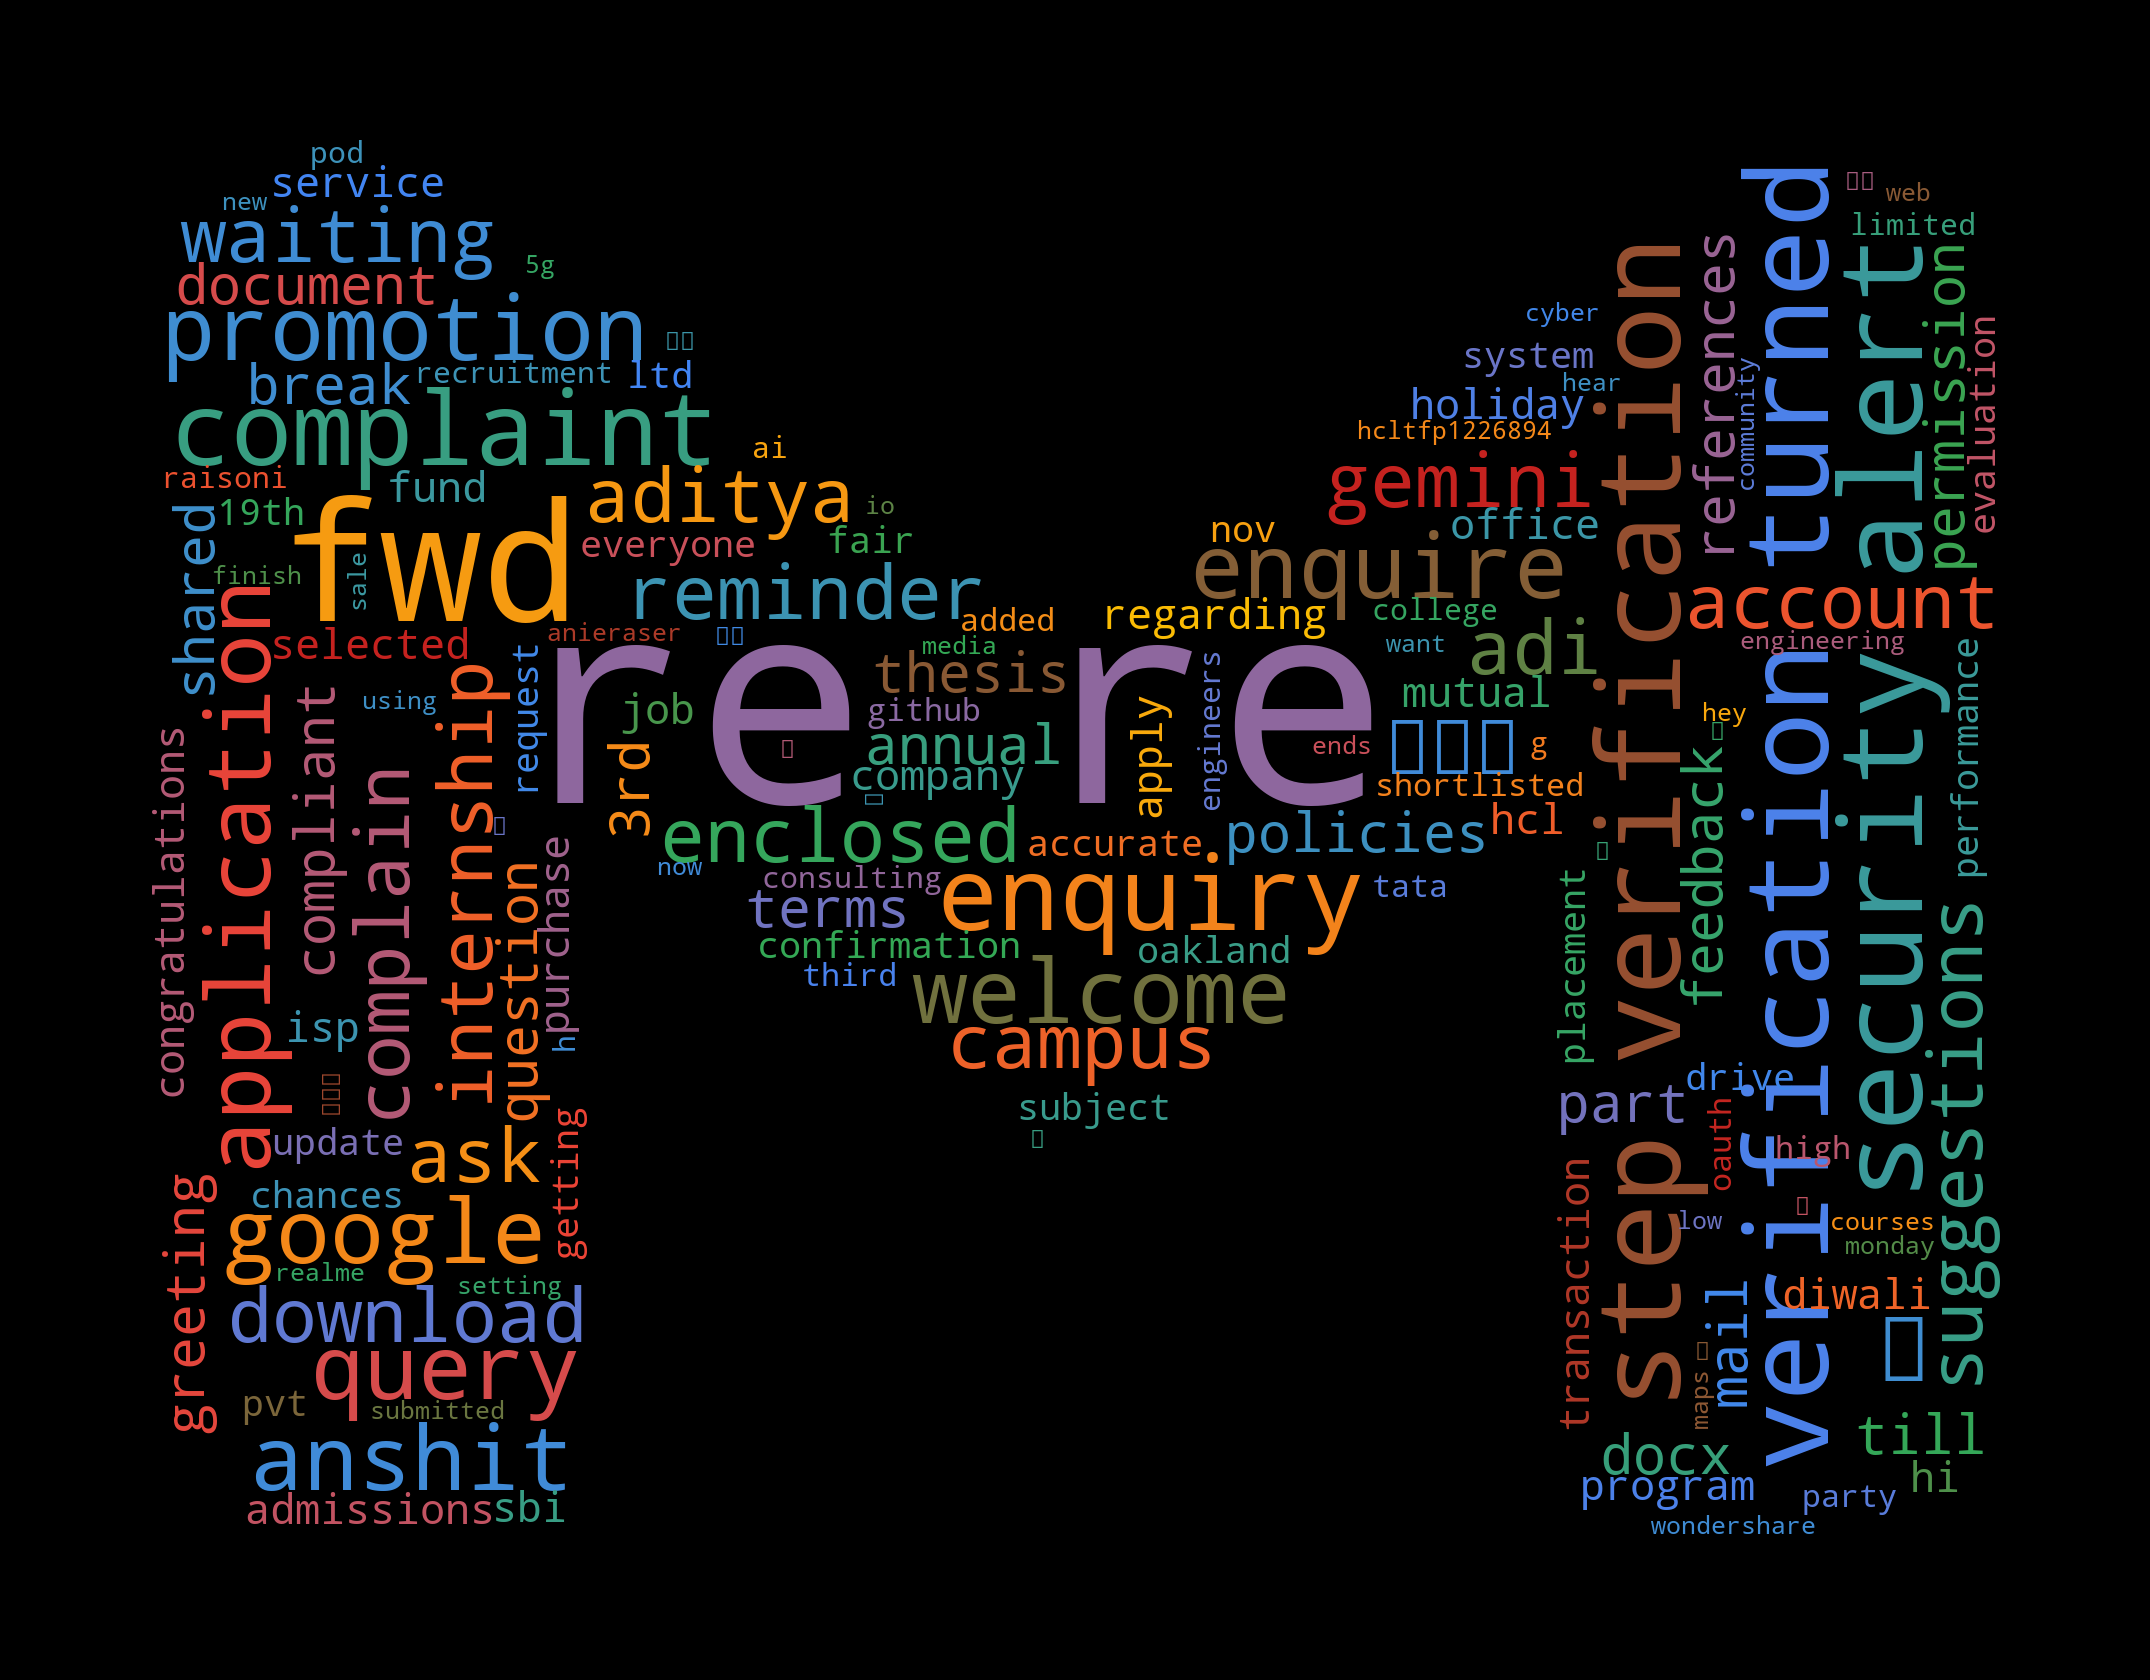

In [9]:
# Create a string that will contain all the words
total_subjects = ' '
stopwords = STOPWORDS.update(['al', 'of', 'in', 'your', 's', 'the', 'and', 'that', 'you', 'it', 'the', 'the', 'only', 'from', 'for', 'what', 'that', 'has', 'since', 'by', 'already', 'more', 'is', 'with', 'your', 'for', 'oneself', 'the', 'a', 'a', 'the', 'this', 'goes', 'about', 'you', 'the', 'sandro', 'agama', 'is', 'you have notifications', 'this', 'day', 'hello', 'today'])
mask = np.array(Image.open('Resources/gmail.jpg'))

# Extract and accumulate all the subjects from the emails
for message in email_df['Subject'].values:
    subjects = str(message).lower().split()  # Get the lowercase words from each subject
    for subject in subjects:
        total_subjects = total_subjects + subject + ' '  # Accumulate all subjects

wordcloud = WordCloud(scale=2.5, width=1000, height=800, 
                      background_color='black',
                      mask=mask,
                      colormap=gmail,
                      stopwords=stopwords, 
                      min_font_size=6).generate(total_subjects)

# Plot the most used words in the word cloud
wordcloud.to_image()
